In [1]:
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
#set the connection to database
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20231113'
}

In [3]:
#i'm going to make distinct queries for each table

In [5]:
#just check the connection and look at data we got
query = '''
    SELECT *
    FROM  simulator_20231113.feed_actions
    limit 270000      
    '''

check_table = ph.read_clickhouse(query=query, connection=connection)
check_table.head()

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,148500,3137,view,2023-11-09 20:43:41,0,23,Russia,Saint Petersburg,Android,organic,0
1,4578,3118,view,2023-11-09 20:43:42,0,22,Russia,Moscow,Android,ads,0
2,12459,3181,view,2023-11-09 20:43:42,0,17,Russia,Protvino,Android,ads,1
3,30196,2989,view,2023-11-09 20:43:42,1,29,Russia,Apsheronsk,Android,ads,4
4,36941,3129,view,2023-11-09 20:43:42,1,33,Russia,Krasavino,iOS,ads,3


In [6]:
#let's add column with month name and age group
check_table['Month'] = pd.to_datetime(check_table['time'], format='%d').dt.strftime('%B')

In [7]:
def age_group(x):
    if (x < 14):
        return 'дети'
    elif (14 <= x < 21):
        return 'подростки'
    elif (21 <= x < 35):
        return 'молодежь'
    elif (35 <= x < 60):
        return 'взрослые'
    elif (x >= 60):
        return 'пожилые'

In [8]:
check_table = check_table.assign(age_group=check_table['age'].apply(age_group))

In [9]:
check_table.head()

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group,Month,age_group
0,148500,3137,view,2023-11-09 20:43:41,0,23,Russia,Saint Petersburg,Android,organic,0,November,молодежь
1,4578,3118,view,2023-11-09 20:43:42,0,22,Russia,Moscow,Android,ads,0,November,молодежь
2,12459,3181,view,2023-11-09 20:43:42,0,17,Russia,Protvino,Android,ads,1,November,подростки
3,30196,2989,view,2023-11-09 20:43:42,1,29,Russia,Apsheronsk,Android,ads,4,November,молодежь
4,36941,3129,view,2023-11-09 20:43:42,1,33,Russia,Krasavino,iOS,ads,3,November,молодежь


In [10]:
##DAU WAU MAU

In [11]:
#create table for DAU
query = '''
    SELECT toDate(time) as date, count(distinct user_id) AS "users"
    FROM simulator_20231113.feed_actions
    GROUP BY date
    '''

dau = ph.read_clickhouse(query=query, connection=connection)
dau.head()

,date,users
0,2023-09-28,878
1,2023-09-29,2238
2,2023-09-30,3105
3,2023-10-01,3721
4,2023-10-02,4617


In [12]:
#create table for WAU
query = '''
    SELECT toMonday(toDateTime(time)) AS week,
       count(DISTINCT user_id) AS "users"
    FROM simulator_20231113.feed_actions
    GROUP BY toMonday(toDateTime(time))
    ORDER BY "users" DESC
    '''

wau = ph.read_clickhouse(query=query, connection=connection)
wau.head()

,week,users
0,2023-12-25,87602
1,2023-12-18,85090
2,2023-12-11,82299
3,2023-12-04,81405
4,2023-11-27,79740


In [13]:
#create table for MAU
query = '''
    SELECT toStartOfMonth(toDateTime(time)) AS month,
       count(DISTINCT user_id) AS "users"
    FROM simulator_20231113.feed_actions
    GROUP BY toStartOfMonth(toDateTime(time))
    ORDER BY "users" DESC
    '''

mau = ph.read_clickhouse(query=query, connection=connection)
mau.head()

,month,users
0,2023-12-01,146810
1,2023-11-01,119737
2,2024-01-01,71594
3,2023-10-01,65226
4,2023-09-01,4546


In [14]:
mau['month_name'] = pd.to_datetime(mau['month'], format='%d').dt.strftime('%B')
mau.head()

,month,users,month_name
0,2023-12-01,146810,December
1,2023-11-01,119737,November
2,2024-01-01,71594,January
3,2023-10-01,65226,October
4,2023-09-01,4546,September


In [15]:
#DAILY ACTIVITY
query = '''
    SELECT toDate(time) as date, countIf(action = 'like') AS like , countIf(action = 'view') AS view
    FROM simulator_20231113.feed_actions
    GROUP BY date
    '''

actions = ph.read_clickhouse(query=query, connection=connection)
actions.head()

,date,like,view
0,2023-09-28,1560,7603
1,2023-09-29,12816,62770
2,2023-09-30,20958,105526
3,2023-10-01,23800,118996
4,2023-10-02,34504,174454


In [16]:
#TOP POSTS
query = '''
    SELECT post_id AS post_id,
       countIf(action='view') AS "view",
       countIf(action='like') AS "likes",
       countIf(action='like') / countIf(action='view') AS "CTR",
       COUNT(DISTINCT user_id) AS "coverage"
    FROM simulator_20231113.feed_actions
    GROUP BY post_id
    ORDER BY likes DESC
    '''

posts = ph.read_clickhouse(query=query, connection=connection)
posts.head()

,post_id,view,likes,CTR,coverage
0,3129,118637,32703,0.275656,51178
1,4844,102434,30849,0.301160,53761
2,6474,92927,28038,0.301721,53546
3,6368,92552,28020,0.302749,52173
4,4188,93790,27583,0.294093,49809


In [17]:
#USERS FLOW
query = '''
    SELECT toDate(this_week) AS this_week,
       status AS status,
       sum(num_users) AS "amount"
    FROM
      (SELECT this_week,
              previous_week, -uniq(user_id) as num_users,
                              status
       FROM
         (SELECT user_id,
                 groupUniqArray(toMonday(toDate(time))) as weeks_visited,
                 addWeeks(arrayJoin(weeks_visited), +1) this_week,
                 if(has(weeks_visited, this_week) = 1, 'old', 'gone') as status,
                 addWeeks(this_week, -1) as previous_week
          FROM simulator_20231113.feed_actions
          group by user_id)
       where status = 'gone'
       group by this_week,
                previous_week,
                status
       HAVING this_week != addWeeks(toMonday(today()), +1)
       union all SELECT this_week,
                        previous_week,
                        toInt64(uniq(user_id)) as num_users,
                        status
       FROM
         (SELECT user_id,
                 groupUniqArray(toMonday(toDate(time))) as weeks_visited,
                 arrayJoin(weeks_visited) this_week,
                 if(has(weeks_visited, addWeeks(this_week, -1)) = 1, 'old', 'new') as status,
                 addWeeks(this_week, -1) as previous_week
          FROM simulator_20231113.feed_actions
          group by user_id)
       group by this_week,
                previous_week,
                status) AS virtual_table
    GROUP BY this_week,
             status
    ORDER BY "amount" ASC
    '''
users_flow = ph.read_clickhouse(query=query, connection=connection)
users_flow.head()

,this_week,status,amount
0,2024-01-08,gone,-71752
1,2024-01-01,gone,-44654
2,2023-12-25,gone,-33882
3,2023-12-18,gone,-32296
4,2023-12-11,gone,-30681


In [18]:
#change the column type, because the sns don't recognize current one
users_flow['this_week'] =pd.to_datetime(users_flow['this_week']).dt.to_period('D')

In [19]:
#RETENTION REATE (BY CATEGORY)
query = '''
    select source, days, active_users/ percent * 100 as rate
    from
        (
        select source, days, sum(active_users) as active_users, MAX(active_users) over(partition by source) as percent
        from
            (
            select source, active_users, dateDiff('day', start_date, date) as days
            from 
                (
                select source, toDate(start_date) as start_date,  toDate(date)as date, count( user_id) as active_users
                from

                (select user_id, source, min(toDate(time)) as start_date 
                from simulator_20231113.feed_actions
                group by user_id, source
                having start_date = '2023-11-07'
                ) t1

                join

                (select distinct user_id,source, toDate(time) as date
                from simulator_20231113.feed_actions) t2
                using user_id

                group by source, date, start_date
                )
            )
        group by days, source
        )
        '''

retention = ph.read_clickhouse(query=query, connection=connection)
retention.head()

,source,days,rate
0,ads,44,1.466049
1,ads,51,1.195988
2,ads,13,1.929012
3,ads,28,1.273148
4,ads,2,4.050926


In [20]:
#Let's look at DAU, WAU, MAU

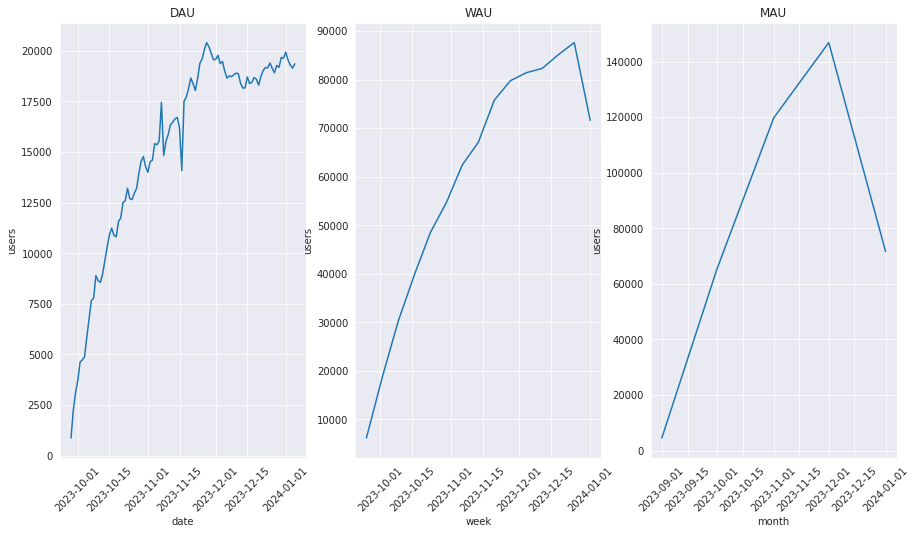

In [23]:
f , axes = plt.subplots(1,3, figsize = (15,8))         #set the params for dashboard
sns.set_style("darkgrid")

fig1 = sns.lineplot(data=dau, x='date', y='users', ax = axes[0])
axes[0].tick_params(axis='x', labelrotation=45)  
axes[0].set_title('DAU')

fig2 = sns.lineplot(data=wau, x='week', y='users', ax = axes[1])
axes[1].tick_params(axis='x', labelrotation=45) 
axes[1].set_title('WAU')

fig3 = sns.lineplot(data=mau, x='month', y='users', ax = axes[2])
axes[2].tick_params(axis='x', labelrotation=45) 
axes[2].set_title('MAU')

plt.show()

In [24]:
#and check some activity

Text(0.5, 1.0, 'Retention rate by Source')

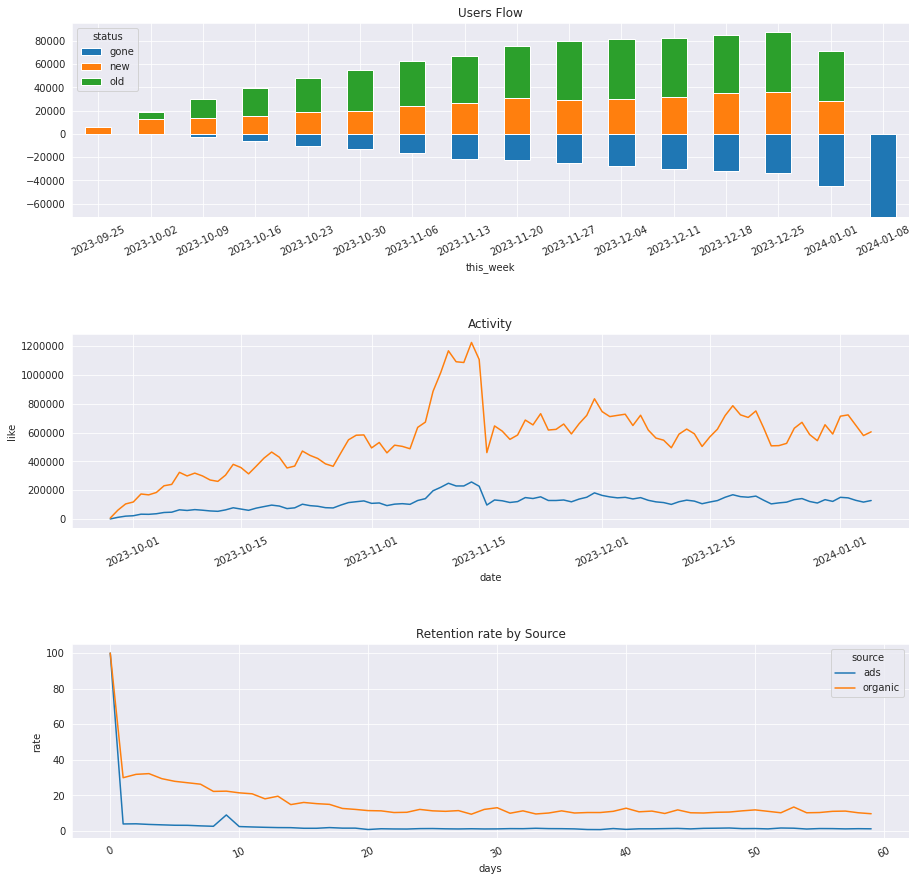

In [25]:
f , axes = plt.subplots(3,1, figsize = (15,15))      #set the params for dashboard
plt.subplots_adjust(hspace=0.6)                      #make space between graphs bigger
plt.ticklabel_format(style='plain', axis='y')
sns.set_style("darkgrid")

pivot_table = users_flow.pivot(index='this_week', columns='status', values='amount')
fig1 = pivot_table.plot(kind='bar', stacked=True, ax = axes[0])
axes[0].tick_params(axis='x', labelrotation=25)  
axes[0].set_title('Users Flow')

fig2 = sns.lineplot(data=actions, x='date',y='like', ax = axes[1])
sns.lineplot(data=actions, x='date',y='view', ax = axes[1])
axes[1].tick_params(axis='x', labelrotation=25)  
axes[1].set_title('Activity')
axes[1].ticklabel_format(style='plain', axis='y')

fig3 = sns.lineplot(data=retention, x='days', y='rate', hue='source', ax = axes[2])
axes[2].tick_params(axis='x', labelrotation=25)  
axes[2].set_title('Retention rate by Source')

In [26]:
# P.S. In my opinion, it is much quicker, easier, and more aesthetic to create dashboards using special tools such as SuperSet, Redash, Tableau, etc and use Pandas for data editing, statistics, and other tasks.
